In [1]:
import numpy as np  

# matplotlib
# ライブラリーのインポート
import matplotlib.pyplot as plt
# インライン表示
%matplotlib inline
# 日本語フォント
import pylab
from matplotlib.font_manager import FontProperties

# ipynbのインポート
import nbimporter
from common_data import get_calendar

Importing Jupyter notebook from common_data.ipynb


# 家電機器

## 10.　電気ポット（ver自立P4）

### 10.1　定義

電気ポットの動作状態および機能は、以下を想定する。

* 稼働－湯沸かし
* 待機－保温

想定する動作状態および機能に対応する添え字は、以下のとおりである。なお、機器の動作状態機能との対応が単純であるため、機能に対応する添え字は省略する。  

|居住者による使用状態 |機器の電源接続状態 |機器の動作状態 |機器の機能 |添え字 |備考  　　　|  
|:-------------------:|:-----------------:|:-------------:|:---------:|:-----:|:----------:|    
|使用                 |AC電源接続         |稼働           |湯沸かし   |opg    |-     　　　|  
|非使用               |AC電源接続         |待機           |保温       |sby    |-     　　　| 

### 10.2　消費電力量

日付$d$の時刻$t$における電気ポットの消費電力量$E_{E,Kettle,d,t}$は、式(1)により表される。

$$ 
\begin{equation*}
    E_{E,Kettle,d,t} = E_{E,opg,d,t} + E_{E,sby,d,t} 
\end{equation*}
$$


<div style="text-align: right;"> (1) </div>

ここで、  

$E_{E,Kettle,d,t}$：日付$d$の時刻$t$における電気ポットの単位時間当たりの消費電力量[Wh]  
$E_{E,opg,d,t}$：日付$d$の時刻$t$における稼働時の単位時間当たりの消費電力量[Wh]  
$E_{E,sby,d,t}$：日付$d$の時刻$t$における待機時の単位時間当たりの消費電力量[Wh]  

である。

In [2]:
def EE_app (EE_opg, EE_sby):
    '''消費電力量[Wh]を計算する'''
    # EE_opg：稼働時の消費電力量[Wh]
    # EE_sby：待機時の消費電力量[Wh]
    
    return EE_opg + EE_sby

日付$d$の時刻$t$における稼働時の消費電力量$E_{E,opg,d,t}$および待機時の消費電力量$E_{E,sby,d,t}$は、式(2)および式(3)により計算される。

<p style="text-indent:2em">稼働時の消費電力量：</p>  
$$ 
\begin{equation*}
    E_{E,opg,d,t} = P_{opg} \times dt_{opg,d,t} \div 3600
\end{equation*}
$$


<div style="text-align: right;"> (2) </div>

<p style="text-indent:2em">待機時の消費電力量：</p>  
$$ 
\begin{equation*}
    E_{E,sby,d,t} = P_{sby} \times dt_{sby,d,t} \div 3600
\end{equation*}
$$


<div style="text-align: right;"> (3) </div>

ただし、式(4)を満たす。
$$ 
\begin{equation*}
    dt_{opg,d,t} + dt_{sby,d,t} = dt_{calc}
\end{equation*}
$$
<div style="text-align: right;"> (4) </div>

ここで、  

$dt_{calc}$：単位時間[s]   
$dt_{opg,d,t}$：日付$d$の時刻$t$における稼働時間の合計[s]  
$dt_{sby,d,t}$：日付$d$の時刻$t$における待機時間の合計[s]   
$E_{E,opg,d,t}$：日付$d$の時刻$t$における稼働時の単位時間当たりの消費電力量[Wh]   
$E_{E,sby,d,t}$：日付$d$の時刻$t$における待機時の単位時間当たりの消費電力量[Wh]   
$P_{opg}$：稼働時の平均消費電力[W]  
$P_{sby}$：待機時の消費電力[W]  

である。

In [3]:
def EE_opg (P_opg, dt_opg):
    '''稼働時の消費電力量[Wh]を計算する'''
    # P_opg：稼働時の消費電力[W]    
    # dt_opg：稼働時間の合計[s]
  
    return P_opg * dt_opg / 3600

In [4]:
def EE_sby (P_sby, dt_sby):
    '''待機時の消費電力量[Wh]を計算する'''
    # P_sby：待機時の消費電力[W]
    # dt_sby：待機時間の合計[s]
 
    return P_sby * dt_sby  / 3600

In [5]:
def check_duration (dt):
    '''合計が単位時間を超過しないか否かを確認する'''
    # dt：稼働時間の合計[s](list型)
    # dt_calc：単位時間[s]
    
    dt_calc = 3600.
    
    # 継続時間を積算する
    dt_sum = sum(dt)
    
    # エラーチェック
    if dt_calc != dt_sum:
        # 単位時間と異なる => エラー
        try:
            raise Exception('機器動作スケジュールに不正があります。')
        except Exception:
            raise
    else:
        pass

### 10.3　稼働時の消費電力

日付$d$の時刻$t$における稼働時の消費電力は、式(5)により計算される。

<p style="text-indent:2em">稼働時の消費電力：</p>  
$$ 
\begin{equation*}
    P_{opg} = E_{E,msrd,opg}
\end{equation*}
$$

<div style="text-align: right;"> (5) </div>

ここで、   

$P_{opg}$：稼働時の平均消費電力[W]  
$E_{E,msrd,opg}$：湯沸かし時における１時間当たりの消費電力量の実測値[Wh/h]  

である。

In [6]:
def P_opg (EE_msrd_opg):
    '''稼働時の消費電力[W]を計算する''' 
    # EE_msrd_opg：湯沸かし時における１時間当たりの消費電力量の実測値[Wh/h]  
    
    return EE_msrd_opg

### 10.4　待機時の消費電力

日付$d$の時刻$t$における待機時の消費電力は、式(6)により計算される。

<p style="text-indent:2em">待機時の消費電力：</p>  
$$ 
\begin{equation*}
    P_{sby} = P_{msrd,sby} 
\end{equation*}
$$

<div style="text-align: right;"> (6) </div>

ここで、   

$P_{sby}$：待機時の消費電力[W]  
$P_{msrd,sby}$：待機時における消費電力の実測値[W]  

である。

In [7]:
def P_sby (P_msrd_sby):
    '''待機時の消費電力[W]を計算する''' 
    # P_msrd_sby：待機時における消費電力の実測値[W]    
    
    return P_msrd_sby

### 10.5　標準条件

#### 10.5.1　機器仕様

4人世帯の標準的な機器仕様として、下表の設定を用いることができる。

|番号 |湯沸かし時１時間当たりの消費電力量の実測値[Wh/h] |保温時消費電力の実測値[W] |タイプ                   |備考                |  
|:---:|:-----------------------------------------------:|:------------------------:|:-----------------------:|:------------------:|
|00   |2833.6                                           |28.24                     |電気ポット               |-                   |    
|01   |2669.2                                           |20.91                     |魔法瓶電気ポット         |-                   |    
|02   |2463.2                                           |8.7                       |魔法瓶電気ポット(省エネ) |-                   |    
|03   |2590.8                                           |0.0                       |電気ケトル               |4人標準世帯の既定値 |    

In [8]:
Spec  = {
    'Kettle00' : {
        'EE_msrd_opg' : 2833.6,
        'P_msrd_sby'  : 28.24
    }, 
    'Kettle01' : {
        'EE_msrd_opg' : 2669.2,
        'P_msrd_sby'  : 20.91
    },
    'Kettle02' : {
        'EE_msrd_opg' : 2463.2,
        'P_msrd_sby'  : 8.7
    },
    'Kettle03' : {
        'EE_msrd_opg' : 2590.8,
        'P_msrd_sby'  : 0.0
    }
}

#### 10.5.2　機器動作スケジュール

4人世帯の標準的なスケジュールとして、下表の設定を用いることができる。

|番号 |スケジュール名称   |備考 |  
|:---:|:-----------------:|:---:|  
|00   |4人標準世帯        |-    |  

<p style="text-indent:2em">平日：</p>  

|時刻                |0  |1  |2  |3  |4  |5  |6  |7  |8  |9  |10 |11 |12 |13 |14 |15 |16 |17 |18 |19 |20 |21 |22 |23 |  
|:---:               | -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:|  
|稼働時間[\* 60 s]   |  0|  0|  0|  0|  0|  0|  5|  0|  0|  0|  0|  0|  5|  0|  0|  0|  0|  5|  0|  0|  0|  0|  0|  0|  
|待機時間[\* 60 s]   | 60| 60| 60| 60| 60| 60| 55| 60| 60| 60| 60| 60| 55| 60| 60| 60| 60| 55| 60| 60| 60| 60| 60| 60| 

<p style="text-indent:2em">休日在宅：</p>  

|時刻                |0  |1  |2  |3  |4  |5  |6  |7  |8  |9  |10 |11 |12 |13 |14 |15 |16 |17 |18 |19 |20 |21 |22 |23 |  
|:---:               | -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:|  
|稼働時間[\* 60 s]   |  0|  0|  0|  0|  0|  0|  0|  5|  0|  0|  0|  0|  5|  0|  0|  0|  5|  0|  0|  0|  0|  0|  0|  0|  
|待機時間[\* 60 s]   | 60| 60| 60| 60| 60| 60| 60| 55| 60| 60| 60| 60| 55| 60| 60| 60| 55| 60| 60| 60| 60| 60| 60| 60| 

<p style="text-indent:2em">休日外出：</p>  

|時刻                |0  |1  |2  |3  |4  |5  |6  |7  |8  |9  |10 |11 |12 |13 |14 |15 |16 |17 |18 |19 |20 |21 |22 |23 |  
|:---:               | -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:|  
|稼働時間[\* 60 s]   |  0|  0|  0|  0|  0|  0|  0|  0|  5|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  5|  0|  0|  0|  
|待機時間[\* 60 s]   | 60| 60| 60| 60| 60| 60| 60| 60| 55| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 55| 60| 60| 60| 

In [9]:
Schedule= {
    '4p_standard' : {
        'Weekdays' : {
            'opg' : [0]   *6 + [300] *1 + [0]   *5 + [300] *1 + [0]   *4 + [300] *1 + [0]   *6,
            'sby' : [3600]*6 + [3300]*1 + [3600]*5 + [3300]*1 + [3600]*4 + [3300]*1 + [3600]*6
        },
        'Holidays_st' : {
            'opg' : [0]   *7 + [300] *1 + [0]   *4 + [300] *1 + [0]   *3 + [300] *1 + [0]   *7,
            'sby' : [3600]*7 + [3300]*1 + [3600]*4 + [3300]*1 + [3600]*3 + [3300]*1 + [3600]*7
        },
        'Holidays_go' : {
            'opg' : [0]   *8 + [300] *1 + [0]   *11 + [300] *1 + [0]   *3,
            'sby' : [3600]*8 + [3300]*1 + [3600]*11 + [3300]*1 + [3600]*3
        }
    }
}

In [10]:
def plot_hourly_bar_chart(fig_title, y_value_sets, schedule_name, app_status_types, 
                          y_label, y_lower, y_upper, y_interval, y_convert_unit):
    '''横軸が時刻（1時間間隔、0～23時間）の棒グラフを作成する'''
    # fig_title：図のタイトル
    # y_value_sets：y軸の値
    # schedule_name：スケジュール名（string型）
    # app_status_types：動作状態のタイプ（dictionary型）
    # y_label：y軸のラベル
    # y_lower：y軸の表示の下限
    # y_ upper：y軸の表示の上限
    # y_ interval：y軸の目盛間隔
    # y_convert_unit：y軸の単位換算係数

    # 日本語フォント
    fp = FontProperties(fname='C:\WINDOWS\Fonts\msgothic.ttc', size = 12)
    
    # 既存スタイルの使用
    plt.style.use('seaborn-whitegrid')

    # サブプロットの作成
    plt.figure(figsize=(12, 3), dpi=80)
    
    # サブプロットのタイトル
    plt.suptitle(fig_title, fontdict={'fontproperties':fp}, fontsize=14)
    
    # 生活時間タイプ
    time_use_types = [ ('Weekdays','平日'), ('Holidays_st','休日在宅'), ('Holidays_go','休日外出') ]

    for i, time_use_type in enumerate(time_use_types):
        # サブプロットの指定
        ax = plt.subplot2grid((1, 3), (0, i))  
        
        for j, app_status_type in enumerate(list(app_status_types)):
            # 棒グラフの作成
            # x軸の値
            x_value = [k for k in range(24)]
            # y軸の値（24時間×動作状態×3スケジュール）
            y_value_sets_schedule = y_value_sets
            # y軸の値（24時間×動作状態）
            y_value_sets_time_use = y_value_sets_schedule[time_use_type[0]]
            # y軸の値（24時間->単位変換）
            y_value = np.array(y_value_sets_time_use[app_status_type]) * y_convert_unit
            # データ系列名
            app_status_type_jp = app_status_types[app_status_type]
            if len(y_value) > 0:
                if j == 0:
                    ax.bar(x_value, y_value, align='edge', width=1.0, edgecolor='black', label=app_status_type_jp)
                    y_bottom = y_value
                else:
                    ax.bar(x_value, y_value, align='edge', width=1.0, edgecolor='black', label=app_status_type_jp, bottom=y_bottom)
                
        # グラフのタイル
        schedule_name_jp = schedule_name
        ax.set_title(schedule_name_jp +'(' + time_use_type[1] + ')' , fontdict={'fontproperties':fp})

        # x軸
        # タイトル
        ax.set_xlabel(u'時刻', fontdict={'fontproperties':fp})
        # 目盛りの位置／ラベル／形式
        # 主目盛
        ax.set_xticks(np.arange(0, 25, 3), minor=False)
        ax.set_xticklabels(np.array([k*3 for k in range(8)]+[0]).astype('str'), minor=False, visible=True)
        ax.tick_params(axis='x', which ='major', direction='in', length=3)
        # 補助目盛
        ax.set_xticks(np.arange(0, 25, 1), minor=True)
        ax.set_xticklabels(np.array([k for k in range(24)]+[0]).astype('str'), minor=True, visible=False)
        ax.tick_params(axis='x', which ='minor', direction='in', length=3)
        # 表示の上限・下限
        ax.set_xbound(lower=0, upper=24)

        # y軸
        #タイトル
        ax.set_ylabel(y_label, fontdict={'fontproperties':fp}) 
        # 目盛りの位置／形式
        #ax.set_yticks(np.arange(0, 30, 5))
        ax.set_yticks(np.arange(y_lower, y_upper+y_interval, y_interval))
        ax.tick_params(axis='y', which ='major', direction='in', length=3)
        # 表示の上限・下限
        ax.set_ybound(lower=y_lower, upper=y_upper)

        # グラフの枠
        ax.spines['right'].set_color('black')
        ax.spines['left'].set_color('black')
        ax.spines['bottom'].set_color('black')
        ax.spines['top'].set_color('black')

        # 主目盛りのグリッド
        ax.grid(which='major', color='lightgray', alpha=0.7, linestyle='-')

    # 凡例
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), borderaxespad=0.5, frameon=True,  prop=fp)

    # グラフの重なりを解消
    plt.tight_layout()
    plt.subplots_adjust(top=0.82)
  
    plt.show()

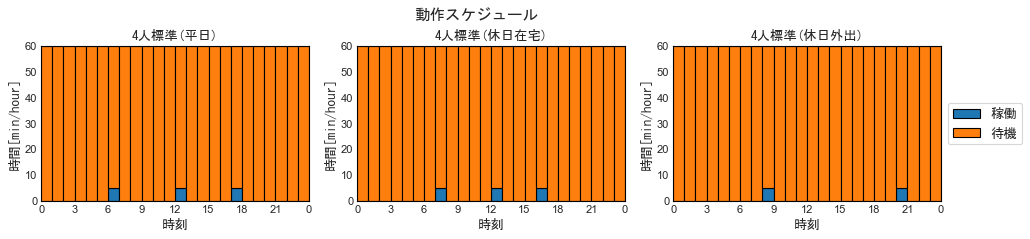

In [11]:
# 機器動作スケジュールの確認
plot_hourly_bar_chart('動作スケジュール', 
                      Schedule['4p_standard'], 
                      '4人標準',
                      {'opg':'稼働', 'sby':'待機'},
                       '時間[min/hour]', 0, 60, 10, 1/60)

### 付録1：サンプルコード

4人標準世帯の標準条件について、サンプルコードを示す。

In [12]:
def get_spec(app_type):
    '''機器仕様を取得する'''
    # app_type：機器タイプ
    
    # 機器仕様の取得
    try:
        spec = Spec[app_type]
    except:
        raise Exception('機器タイプの入力に不正があります。')     
    
    EE_msrd_opg = spec['EE_msrd_opg']
    P_msrd_sby = spec['P_msrd_sby']
    
    return EE_msrd_opg, P_msrd_sby

Example:

In [13]:
ex_EE_msrd_opg, ex_P_msrd_sby = get_spec('Kettle03')
ex_EE_msrd_opg, ex_P_msrd_sby

(2590.8, 0.0)

In [14]:
def get_dt(time_use_type, time_of_day, schedule_name):
    '''機器動作スケジュールを取得する'''
    # time_use_type：['Weekdays', 'Holidays_st', 'Holidays_go']
    # time_of_day：時刻（0-23）
    # schedule_name：スケジュール名
     
    # スケジュールの取得
    try:
        schedule_set = Schedule[schedule_name][time_use_type]
    except:
        raise Exception('スケジュール名の入力に不正があります。')    
               
    # 動作状態のタイプ
    app_status_types = list(schedule_set)
    
    # 動作状態ごとの継続時間[s]の取得
    for i, app_status_type in enumerate(app_status_types):
        if app_status_type == 'opg':
            dt_opg = schedule_set[app_status_type][time_of_day]
        elif app_status_type == 'sby':
            dt_sby = schedule_set[app_status_type][time_of_day]
        else:
            raise Exception
            
    # 時間超過の確認
    check_duration([dt_opg, dt_sby]) 
    
    return dt_opg, dt_sby

Example:

In [15]:
ex_dt_opg, ex_dt_sby = get_dt('Weekdays', 6, '4p_standard')
ex_dt_opg, ex_dt_sby

(300, 3300)

In [16]:
def calc_EE_opg(EE_msrd_opg, dt_opg):
    '''稼働時における消費電力量[Wh]を計算する'''
    # EE_msrd_opg：湯沸かし時における１時間当たりの消費電力量の実測値[Wh/h]
    # dt_opg：稼働時間の合計[s]
    
    # 稼働時の消費電力[W]
    p_opg = P_opg (EE_msrd_opg)
       
    # 稼働時における消費電力量[Wh]
    ee_opg = EE_opg(p_opg, dt_opg)
    
    return ee_opg

Example:

In [17]:
ex_EE_opg = calc_EE_opg(ex_EE_msrd_opg, ex_dt_opg)
ex_EE_opg

215.9

In [18]:
def calc_EE_sby(P_msrd_sby, dt_sby):
    '''稼働時における消費電力量[Wh]を計算する'''
    # P_msrd_sby：待機時における消費電力の実測値[W]   
    # dt_sby：待機時間の合計[s]
    
    # 稼働時の消費電力[W]
    p_sby = P_sby (P_msrd_sby)
       
    # '稼働時における消費電力量[Wh]
    ee_sby = EE_sby(p_sby, dt_sby)
    
    return ee_sby

Example:

In [19]:
ex_EE_sby = calc_EE_sby(ex_P_msrd_sby, ex_dt_sby)
ex_EE_sby

0.0

In [20]:
def calc_EE_app(EE_opg, EE_sby):
    '''消費電力量[Wh]を計算する'''
    # EE_opg：稼働時における消費電力量[Wh]
    # EE_sby：待機時における消費電力量[Wh]
    
    return EE_app(EE_opg, EE_sby)

Example:

In [21]:
ex_EE_app = calc_EE_app(ex_EE_opg, ex_EE_sby)
ex_EE_app

215.9

In [22]:
def calc_EE_Kettle_verP4(time_use_type, time_of_day, app_type, schedule_name):
    '''電気ポットの単位時間当たりの消費電力量を計算する（ver自立P4）'''
    # time_use_type：['Weekdays', 'Holidays_st', 'Holidays_go']
    # time_of_day：時刻（0-23） 
    # app_type：機器タイプ  
    # schedule_name：スケジュール名['4p_standard']
    
    # 機器動作スケジュール[s]を取得
    dt_opg, dt_sby = get_dt(time_use_type, time_of_day, schedule_name)
    
    # 機器仕様を取得
    EE_msrd_opg, P_msrd_sby = get_spec(app_type)
    
    # 稼働時における消費電力量[Wh]を計算
    EE_opg = calc_EE_opg(EE_msrd_opg, dt_opg)
    
    # 待機時における消費電力量[Wh]を計算
    EE_sby = calc_EE_sby(P_msrd_sby, dt_sby)
    
    # 消費電力量[Wh]を計算
    EE_app = calc_EE_app (EE_opg, EE_sby)
    
    return EE_app, EE_opg, EE_sby

Example:

In [23]:
ex_EE_Kettle = calc_EE_Kettle_verP4('Weekdays', 6, 'Kettle03', '4p_standard')
ex_EE_Kettle

(215.9, 215.9, 0.0)

### 付録2：サンプルコードによる時刻別消費電力量の計算例

4人標準世帯の標準条件に対して、サンプルコードにより平日、休日在宅、休日外出の時刻別消費電力量を計算した結果を示す。

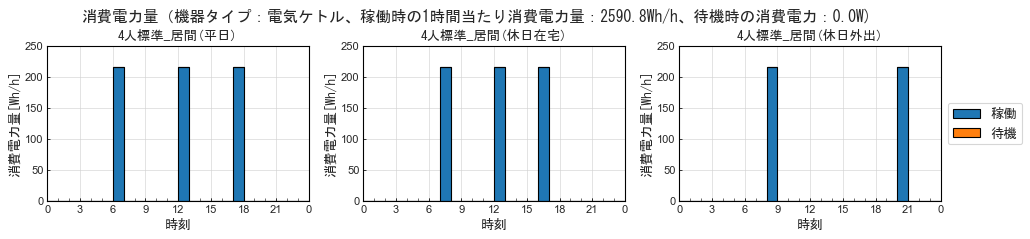

In [24]:
# 消費電力量の計算
# 入力
time_use_type = [['Weekdays'], ['Holidays_st'], ['Holidays_go']]
time_of_day = [i for i in range(0, 24, 1)]
app_type = 'Kettle03'
schedule_name = '4p_standard'

# 消費電力量の計算
ee_app, ee_opg, ee_sby = np.vectorize(calc_EE_Kettle_verP4)(time_use_type, time_of_day, app_type, schedule_name)

# 消費電力量の計算結果
EE_Results= {
    'Weekdays' : {
        'opg' : ee_opg[0],
        'sby' : ee_sby[0]
    },
    'Holidays_st' : {
        'opg' : ee_opg[1],
        'sby' : ee_sby[1]
    },
    'Holidays_go' : {
        'opg' : ee_opg[2],
        'sby' : ee_sby[2]
    }
}

# 消費電力量の計算結果のグラフ
# グラフのタイトル
app_type_j = {'Kettle00': '電気ポット', 'Kettle01': '魔法瓶電気ポット', 
              'Kettle01': '魔法瓶電気ポット(省エネ)', 'Kettle03': '電気ケトル'}[app_type]

chart_title = '消費電力量（' \
                + '機器タイプ：' + app_type_j + '、' \
                + '稼働時の1時間当たり消費電力量：' + str(Spec[app_type]['EE_msrd_opg']) + 'Wh/h、' \
                + '待機時の消費電力：' + str(Spec[app_type]['P_msrd_sby'])+ 'W' \
                + ')'

# グラフの表示                
plot_hourly_bar_chart(chart_title, 
                      EE_Results, 
                      '4人標準_居間',
                      {'opg':'稼働', 'sby':'待機'},
                       '消費電力量[Wh/h]', 0, 250, 50, 1)

### 付録3：サンプルコードによる年間消費電力量の計算例

4人標準世帯の標準条件に対して、サンプルコードにより年間消費電力量を計算した結果を示す。

In [25]:
def calc_annual_EE_app(app_type, schedule_name):
    '''年間消費電力量[Wh/year]を計算する'''
    # app_type：機器タイプ  
    # schedule_name：スケジュール名  
       
    def calc_daily_EE_app(schedule, app_type, schedule_name):
        '''1日あたりの消費電力量[Wh/day]を計算する'''
        hourly_EE_app = [ calc_EE_Kettle_verP4(schedule, t, app_type, schedule_name)[1] for t in range(0, 24, 1) ]
        return sum( hourly_EE_app )
    
    daily_EE_app = [ calc_daily_EE_app(schedule, app_type, schedule_name) for schedule in get_calendar() ]
    return sum( daily_EE_app )

In [26]:
# 年間消費電力量[kWh/year]
ex_annual_EE_app = calc_annual_EE_app('Kettle03', '4p_standard')
print('年間消費電力量：' + str(ex_annual_EE_app/1000) + ' kWh/年')

年間消費電力量：229.93350000000117 kWh/年
